# Import Libraries

In [16]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso

# Obtain Data

Read csv with happiness data into Pandas

In [2]:
df = pd.read_csv('Data/world-happiness-report.csv')
df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268


# Scrub Data

Calculate number of datapoints by year in order to determine which year to use for modeling

In [3]:
df.groupby('year').count()['Country name']

year
2005     27
2006     89
2007    102
2008    110
2009    114
2010    124
2011    146
2012    142
2013    137
2014    145
2015    143
2016    142
2017    147
2018    142
2019    144
2020     95
Name: Country name, dtype: int64

Use data for 2017 in modeling and drop data for all other years from the df

In [4]:
df = df[df['year']==2017]
df.reset_index(drop=True, inplace=True)
df.drop(columns='year', inplace=True)
df.head()

,Country name,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2.662,7.697,0.491,52.8,0.427,-0.121,0.954,0.496,0.371
1,Albania,4.640,9.476,0.638,68.4,0.750,-0.029,0.876,0.669,0.334
2,Algeria,5.249,9.354,0.807,65.7,0.437,-0.167,0.700,0.642,0.289
3,Argentina,6.039,10.067,0.907,68.6,0.832,-0.186,0.841,0.809,0.292
4,Armenia,4.288,9.402,0.698,66.6,0.614,-0.147,0.865,0.625,0.437


use df.info() to determine what scrubbing needed

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      147 non-null    object 
 1   Life Ladder                       147 non-null    float64
 2   Log GDP per capita                146 non-null    float64
 3   Social support                    146 non-null    float64
 4   Healthy life expectancy at birth  143 non-null    float64
 5   Freedom to make life choices      146 non-null    float64
 6   Generosity                        145 non-null    float64
 7   Perceptions of corruption         137 non-null    float64
 8   Positive affect                   146 non-null    float64
 9   Negative affect                   146 non-null    float64
dtypes: float64(9), object(1)
memory usage: 11.6+ KB


Drop object variables and other variables not useful for modeling

In [6]:
df.drop(columns=['Country name', 'Positive affect', 'Negative affect'], inplace=True)
df.head()

,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption
0,2.662,7.697,0.491,52.8,0.427,-0.121,0.954
1,4.640,9.476,0.638,68.4,0.750,-0.029,0.876
2,5.249,9.354,0.807,65.7,0.437,-0.167,0.700
3,6.039,10.067,0.907,68.6,0.832,-0.186,0.841
4,4.288,9.402,0.698,66.6,0.614,-0.147,0.865


Replace missing values with knn imputer

In [7]:
knn_x = df.drop(columns='Life Ladder')
knn_ss = StandardScaler()
ss_knn_x = pd.DataFrame(knn_ss.fit_transform(knn_x), columns=knn_x.columns)
knn_imputer = KNNImputer()
imputed_x = pd.DataFrame(knn_imputer.fit_transform(ss_knn_x), columns=ss_knn_x.columns)
scrubbed_df = pd.concat([df[['Life Ladder']], imputed_x], axis=1)
scrubbed_df.head()

,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption
0,2.662,-1.444622,-2.580470,-1.598862,-2.786590,-0.726741,1.231530
1,4.640,0.067102,-1.372969,0.610327,-0.241167,-0.142475,0.805470
2,5.249,-0.036569,0.015247,0.227967,-2.707784,-1.018874,-0.155895
3,6.039,0.569310,0.836677,0.638649,0.405040,-1.139538,0.614290
4,4.288,0.004220,-0.880111,0.355420,-1.312924,-0.891860,0.745385


Confirm data is now scrubbed with scrubbed_df.info()

In [8]:
scrubbed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Life Ladder                       147 non-null    float64
 1   Log GDP per capita                147 non-null    float64
 2   Social support                    147 non-null    float64
 3   Healthy life expectancy at birth  147 non-null    float64
 4   Freedom to make life choices      147 non-null    float64
 5   Generosity                        147 non-null    float64
 6   Perceptions of corruption         147 non-null    float64
dtypes: float64(7)
memory usage: 8.2 KB


# Explore Data

Use isolation forest to identify greatest 5% outliers and confirm no need to drop outliers by observing standard scaled datapoints for greatest outliers

In [12]:
if_x = scrubbed_df.drop(columns='Life Ladder')
if_ss = StandardScaler()
ss_if_x = pd.DataFrame(if_ss.fit_transform(if_x), columns=if_x.columns)

isf = IsolationForest(random_state=72, contamination=.05)
isf.fit(ss_if_x)
if_x['Outlier'] = isf.predict(ss_if_x)
if_x[if_x['Outlier']==-1]

,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Outlier
0,-1.444622,-2.580470,-1.598862,-2.786590,-0.726741,1.231530,-1
22,-2.192411,-3.985114,-2.675134,-1.068626,0.505298,0.881942,-1
47,0.748610,-0.428325,1.148462,-2.699904,-1.800012,0.783621,-1
50,-1.633268,-1.299040,-1.216503,-2.337397,2.461319,-0.445397,-1
91,-0.792855,-0.083324,-0.763336,0.830590,4.169662,-0.598341,-1
111,-1.537245,-2.366898,-0.508429,1.003963,0.365582,-2.810573,-1
116,1.753876,0.754534,1.757405,1.145813,0.905393,-3.094613,-1
141,-0.522632,1.124177,0.100514,1.610766,0.822834,-1.439536,-1


Calculate vif to confirm no correlated features with rounded vif above 5 need to be removed

In [35]:
vif_df = add_constant(scrubbed_df.drop(columns='Life Ladder'))
vif_output = []
for num in range(0, len(vif_df.columns)):
    vif_output.append([vif_df.columns[num], variance_inflation_factor(vif_df.values, num)])
pd.DataFrame(vif_output, columns=['Column', 'VIF'])

,Column,VIF
0,const,1.001219
1,Log GDP per capita,5.094881
2,Social support,2.721128
3,Healthy life expectancy at birth,4.324873
4,Freedom to make life choices,1.507982
5,Generosity,1.310756
6,Perceptions of corruption,1.600794


Calculate descriptive statistics for all variables in scrubbed_df

In [11]:
scrubbed_df.describe()

,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption
count,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000
mean,5.460408,-0.011581,0.001177,0.005298,0.002444,-0.001403,0.002274
std,1.140804,1.009810,1.000102,0.993781,1.000439,0.997769,0.987245
min,2.662000,-2.192411,-3.985114,-2.675134,-2.786590,-1.800012,-3.094613
25%,4.619500,-0.775860,-0.588504,-0.727932,-0.528808,-0.815651,-0.303377
50%,5.553000,0.079848,0.187747,0.242128,0.255309,-0.148826,0.297476
75%,6.251500,0.829337,0.820248,0.659892,0.814829,0.632312,0.660719
max,7.788000,1.900885,1.329534,1.757405,1.610766,4.169662,1.231530


Plot distributions of all variables

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

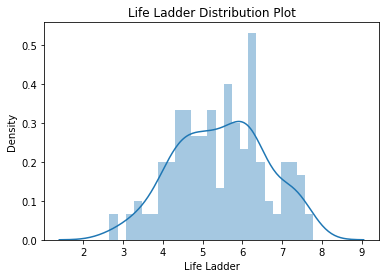

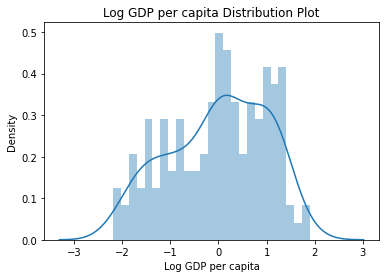

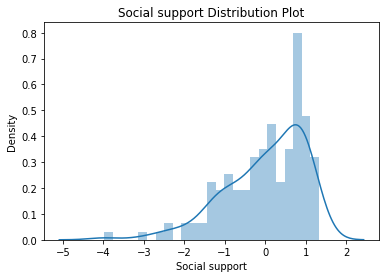

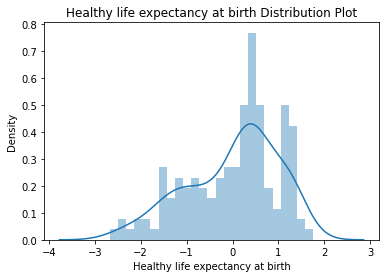

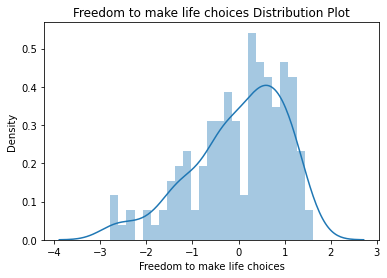

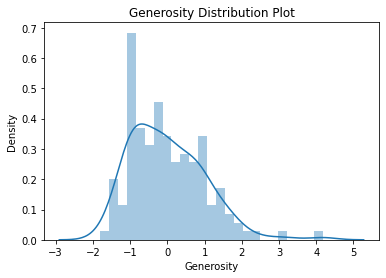

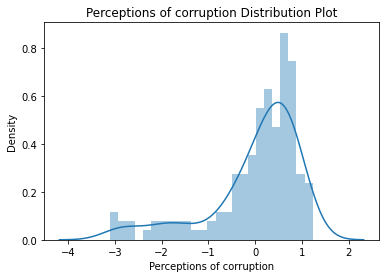

In [12]:
for var in scrubbed_df.columns:
    fig, ax = plt.subplots()
    sns.distplot(scrubbed_df[var], kde=True, bins=25, ax=ax)
    ax.set_title(f'{var} Distribution Plot')

Create pairplots to represent relationships between each x variable and the dependent variable

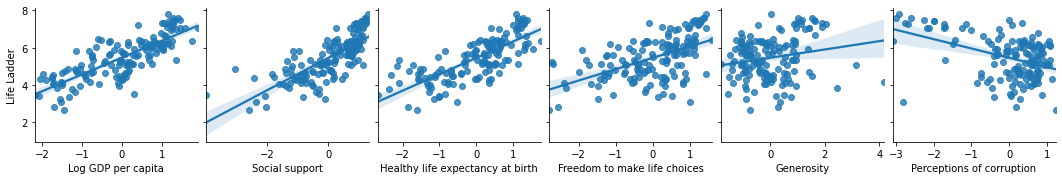

In [13]:
x_vars = list(scrubbed_df.columns)
x_vars.remove('Life Ladder')
sns.pairplot(scrubbed_df, x_vars = x_vars, y_vars=['Life Ladder'], kind='reg')

# Model Data

Create x and y variables for modeling

In [14]:
x = scrubbed_df[x_vars]
y = scrubbed_df['Life Ladder']

Perform train test split on x and y variables

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=73)

Scale data using standard scaler

In [16]:
ss = StandardScaler()
ss.fit(x_train)
x_train = pd.DataFrame(ss.transform(x_train), columns = x.columns)
x_test = pd.DataFrame(ss.transform(x_test), columns = x.columns)

Build and evaluate dummy regressor model

In [17]:
dr = DummyRegressor()
dr.fit(x_train, y_train)
y_train_pred_dr = dr.predict(x_train)
y_test_pred_dr = dr.predict(x_test)
print('Dummy Regressor Model:')
print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, y_train_pred_dr)))
print('Train MAE: ', mean_absolute_error(y_train, y_train_pred_dr))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, y_test_pred_dr)))
print('Test MAE: ', mean_absolute_error(y_test, y_test_pred_dr))



Dummy Regressor Model:
Train RMSE:  1.0843329975931846
Train MAE:  0.9054497520661157
Test RMSE:  1.2817352036963254
Test MAE:  1.0728616707616705


Build and evaluate linear regression model

In [18]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)
print('Linear Regression Model')
print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, y_train_pred_lr)))
print('Train MAE: ', mean_absolute_error(y_train, y_train_pred_lr))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, y_test_pred_lr)))
print('Test MAE: ', mean_absolute_error(y_test, y_test_pred_lr))

Linear Regression Model
Train RMSE:  0.5233380971154052
Train MAE:  0.41421136631699196
Test RMSE:  0.6824841972952349
Test MAE:  0.5746087434142073


Gridsearch Elastic Net model

In [19]:
en_dict = {'alpha': [x * 0.1 for x in range(0, 1001)], 'l1_ratio': [x * 0.1 for x in range(0, 11)]}
en_model = ElasticNet()
en = GridSearchCV(en_model, en_dict, cv=5, n_jobs=-1, 
                     scoring='neg_root_mean_squared_error', verbose=1) 
en.fit(x_train, y_train)
print(en.best_params_)

Fitting 5 folds for each of 11011 candidates, totalling 55055 fits
{'alpha': 0.30000000000000004, 'l1_ratio': 0.0}


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.50491188569574, tolerance: 0.012933558546363636
  model = cd_fast.enet_coordinate_descent(


Build and evaluate elastic net model

In [20]:
en = ElasticNet(alpha=.3, l1_ratio=0)
en.fit(x_train, y_train)
y_train_pred_en = en.predict(x_train)
y_test_pred_en = en.predict(x_test)
print('Elastic Net Model')
print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, y_train_pred_en)))
print('Train MAE: ', mean_absolute_error(y_train, y_train_pred_en))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, y_test_pred_en)))
print('Test MAE: ', mean_absolute_error(y_test, y_test_pred_en))

Elastic Net Model
Train RMSE:  0.5308328961877412
Train MAE:  0.4235435529967286
Test RMSE:  0.7105461208122669
Test MAE:  0.608474270853156


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.504911885695737, tolerance: 0.012933558546363636
  model = cd_fast.enet_coordinate_descent(


# Interpret Data

In [21]:
coefficients_df = pd.DataFrame(lr.coef_)
coefficients_df.columns = ['Coefficient']
coefficients_df['Feature'] = x.columns
coefficients_df.sort_values(by='Coefficient', inplace=True)
coefficients_df

,Coefficient,Feature
5,-0.117930,Perceptions of corruption
4,0.042470,Generosity
3,0.216769,Freedom to make life choices
2,0.219923,Healthy life expectancy at birth
1,0.248905,Social support
0,0.362196,Log GDP per capita


[Text(0, 0, 'Perceptions of corruption'),
 Text(1, 0, 'Generosity'),
 Text(2, 0, 'Freedom to make life choices'),
 Text(3, 0, 'Healthy life expectancy at birth'),
 Text(4, 0, 'Social support'),
 Text(5, 0, 'Log GDP per capita')]

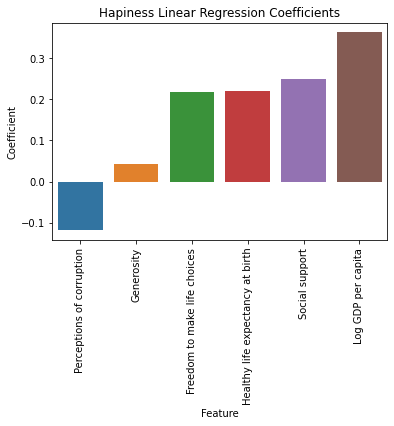

In [22]:
fig, ax = plt.subplots()
sns.barplot(x='Feature', y='Coefficient', data=coefficients_df, ax=ax)
ax.set_title('Hapiness Linear Regression Coefficients')
ax.set_xticklabels(coefficients_df['Feature'], rotation=90)